# CAD Rotation Model – Pre‑processing Notebook

Reusable utilities to prepare annotation *batches* for training a rotation‑aware detection model.
The notebook is idempotent: you can re‑run after dropping in new batches.


## README / Quick‑Start

**Directory layout expected**

```
rotation/
└── batches/
    ├── batch_20250115_01/          # <- renamed input folder
    │   ├── images/
    │   │   └── default/*.png
    │   └── annotations/
    │       └── instances_default.json
    └── ...
```

> ⚠️ If your raw data are still in `rotation/batches/images/default`  
> run section **1 – Rename batches** first.

**Requirements**

```bash
pip install pandas matplotlib pillow
```

The notebook runs entirely offline.

**Lifecycle**

1. **Rename batches** – give each batch a stable, informative folder name.  
2. **Explore JSON** – get counts of images, categories, rotated boxes.  
3. **Visual check** – overlay polygons / bboxes on random images.  
4. **(Optional) Export tidy CSV** – for downstream pipelines.


In [58]:

import os, json, shutil, random, math, datetime as dt
from pathlib import Path
from typing import List, Dict, Any
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon

import json, copy

import math, collections


plt.rcParams['figure.dpi'] = 140  # sharper inline figs


In [61]:

# Where am I?
print("Working dir :", Path.cwd())

# Show the absolute target
batch_dir = Path("../data/rotation/").resolve()
print("Batch dir   :", batch_dir)

# Does it exist?
print("Exists?     :", batch_dir.exists())
print("Contents    :", list(batch_dir.iterdir())[:5])  # peek first 5 entries


Working dir : /Users/gerhardkarbeutz/cerpro/ocr-rec-lab/notebooks
Batch dir   : /Users/gerhardkarbeutz/cerpro/ocr-rec-lab/data/rotation
Exists?     : True
Contents    : [PosixPath('/Users/gerhardkarbeutz/cerpro/ocr-rec-lab/data/rotation/batches')]


In [21]:

# ⇩⇩ Adjust these two lines to match your project root  ⇩⇩
BATCHES_DIR = Path("../data/rotation/batches")               # or Path('/absolute/path/to/project')

print('Batches dir  :', BATCHES_DIR)



Batches dir  : ../data/rotation/batches


## 1 – Rename batches

Raw exports often land in a single folder. The helper below **moves** every `images/default` sibling into a new folder called `batch_<YYYYMMDD>_<nn>`.

Feel free to adapt the scheme.

In [25]:

def rename_batches(batches_dir: Path, prefix: str = 'batch', date_fmt: str = '%Y%m%d') -> None:
    """Rename anonymous batch folders to a canonical pattern.

    Args
    ----
    batches_dir : Path
        The directory that currently holds `images/default` and `annotations/`
        or a flat list of unnamed batches.
    prefix : str
        Prefix used in the target folder name, defaults to 'batch'.
    date_fmt : str
        Date stamp to attach. Default '%%Y%%m%%d'.

    Effect
    ------
    Creates new directory `batches_dir/<prefix>_<date>_<index:02d>` and moves
    `images` and `annotations` inside.
    """    
    today = dt.datetime.today().strftime(date_fmt)
    index = 1
    unnamed = [p for p in batches_dir.iterdir() if p.is_dir() and p.name not in ('images','annotations')]
    # also handle loose images/annotations sitting directly
    if (batches_dir/'images').exists() and (batches_dir/'annotations').exists():
        unnamed.append(batches_dir)
    if not unnamed:
        print('Nothing to rename – folders already structured ✔️')
        return
    for src in unnamed:
        target = batches_dir/f"{prefix}_{today}_{index:02d}"
        index += 1
        target.mkdir(exist_ok=True)
        for sub in ('images', 'annotations'):
            sub_path = src/sub
            if sub_path.exists():
                shutil.move(str(sub_path), target/ sub)
        # remove empty src folder if it wasn't batches_dir
        if src != batches_dir:
            try:
                src.rmdir()
            except OSError:
                pass
        print(f"Moved {src} -> {target}")


In [26]:

# -- Preview rename without executing (dry run) -------------------------------
# Uncomment to execute
rename_batches(BATCHES_DIR)


Moved ../data/rotation/batches/task_sascha qa - lyd text detection batch 1.1_backup_2025_06_12_21_11_59_COCO -> ../data/rotation/batches/batch_20250703_01
Moved ../data/rotation/batches/task_sascha qa - lyd text detection batch 1.2_backup_2025_06_12_21_13_01_COCO -> ../data/rotation/batches/batch_20250703_02


## 2 – Explore a COCO JSON file

In [39]:

def load_coco(json_path: Path) -> Dict[str, Any]:
    with open(json_path, 'r', encoding='utf-8') as f:
        coco = json.load(f)
    return coco



def coco_summary(coco: Dict[str, Any]) -> None:
    print(f"Images      : {len(coco['images']):>5}")
    print(f"Annotations : {len(coco['annotations']):>5}")
    print(f"Categories  : {len(coco['categories']):>5}\n")
    cat_map = {c['id']: c['name'] for c in coco['categories']}
    counts = {}
    for ann in coco['annotations']:
        counts[cat_map[ann['category_id']]] = counts.get(cat_map[ann['category_id']], 0) + 1
    print('Top classes:')
    for k, v in sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:10]:
        print(f"  {k:<25} {v}")

def coco_to_df(coco: Dict[str, Any]) -> pd.DataFrame:
    img_lookup = {img['id']: img for img in coco['images']}
    rows = []
    for ann in coco['annotations']:
        img = img_lookup[ann['image_id']]
        row = {
            'image_id': ann['image_id'],
            'file_name': img['file_name'],
            'width': img['width'],
            'height': img['height'],
            'category_id': ann['category_id'],
            'bbox': ann['bbox'],
            'area': ann.get('area', None),
            'rotation': ann.get('attributes', {}).get('rotation', 0.0),
            'iscrowd': ann.get('iscrowd', 0)
        }
        rows.append(row)
    return pd.DataFrame(rows)


In [33]:
# ────────────────────────────────────────────────────────────────
# 3.  Pick (and sanity-check) a batch folder
# ────────────────────────────────────────────────────────────────
subdirs = sorted(p for p in BATCHES_DIR.iterdir() if p.is_dir())
if not subdirs:
    raise FileNotFoundError(f"No batch folders found in {BATCHES_DIR.resolve()}")

first_batch = subdirs[0]
print("Using batch :", first_batch.name)

# ────────────────────────────────────────────────────────────────
# 4.  Load, summarise, flatten
# ────────────────────────────────────────────────────────────────
json_path = first_batch / "annotations" / "instances_default.json"
coco      = load_coco(json_path)

coco_summary(coco)

df = coco_to_df(coco)
display(df.head())     

Using batch : batch_20250703_01
Images      :    97
Annotations :  4510
Categories  :    13

Top classes:
  text                      4510


,image_id,file_name,width,height,category_id,bbox,area,rotation,iscrowd
0,1,10000.png,3055,2160,7,"[2434.51, 533.13, 35.37, 32.47]",1148.4639,314.6,0
1,1,10000.png,3055,2160,7,"[1165.9, 1001.1, 49.4, 18.9]",933.6600,0.0,0
2,1,10000.png,3055,2160,7,"[1165.7, 1021.8, 49.74, 19.2]",955.0080,0.0,0
3,1,10000.png,3055,2160,7,"[2234.5, 1021.9, 34.1, 19.3]",658.1300,0.0,0
4,1,10000.png,3055,2160,7,"[2175.8, 1006.5, 47.5, 37.8]",1795.5000,0.0,0


In [32]:
second_batch = subdirs[1]
print("Using batch :", second_batch.name)

# ────────────────────────────────────────────────────────────────
# 4.  Load, summarise, flatten
# ────────────────────────────────────────────────────────────────
json_path = second_batch / "annotations" / "instances_default.json"
coco_2      = load_coco(json_path)

coco_summary(coco_2)

df_2 = coco_to_df(coco_2)
display(df_2.head())     

Using batch : batch_20250703_02
Images      :   100
Annotations :  4435
Categories  :    13

Top classes:
  text                      4435


,image_id,file_name,width,height,category_id,bbox,area,rotation,iscrowd
0,1,10232.png,2160,3053,7,"[1074.94, 1238.19, 88.42, 40.3]",3563.3260,270.00,0
1,1,10232.png,2160,3053,7,"[1215.28, 1124.55, 116.28, 40.43]",4701.2004,269.97,0
2,1,10232.png,2160,3053,7,"[606.47, 1532.11, 24.48, 37.44]",916.5312,270.00,0
3,1,10232.png,2160,3053,7,"[413.28, 1413.38, 24.57, 38.12]",936.6084,0.00,0
4,1,10232.png,2160,3053,7,"[413.34, 1356.29, 24.41, 36.53]",891.6973,0.00,0


## 3 – Visual sanity check

Image Path ../data/rotation/batches/batch_20250703_01/images/default/10102.png


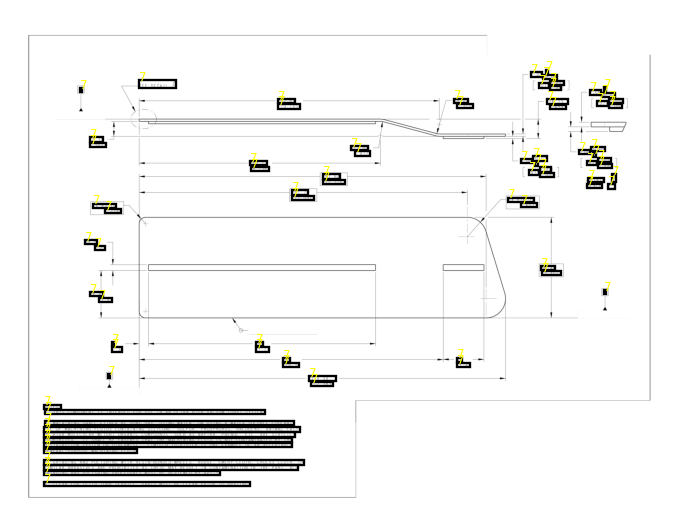

In [34]:

def show_image_with_annotations(image_row: pd.Series, anns: pd.DataFrame, images_dir: Path,
                                show_bbox=True, show_seg=False, alpha=0.3) -> None:
    """Display single image with its rotated bboxes (approx. via matplotlib.transforms)."""
    img_path = images_dir / image_row['file_name']
    
    print(f"Image Path {img_path}")
    
    
    if not img_path.exists():
        print('Image not found:', img_path)
        return
    img = plt.imread(img_path)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(img)
    ax.axis('off')

    subset = anns[anns['image_id'] == image_row['image_id']]
    for _, ann in subset.iterrows():
        x, y, w, h = ann['bbox']
        rot = ann['rotation']
        rect = Rectangle((x, y), w, h, angle=-rot, 
                         linewidth=1.2, fill=False)
        ax.add_patch(rect)
        ax.text(x, y, str(ann['category_id']), fontsize=6, color='yellow')
    plt.show()

# Example: pick random image
sample_row = df.sample(1, random_state=42).iloc[0]


show_image_with_annotations(sample_row, df, first_batch/'images'/'default')


## 4 – Debugging tips and next steps
- Add `assert` statements after every transformation.
- Use `df.query()` to inspect edge cases (e.g. large rotation angles).
- When overlays look wrong, print the raw `bbox` and `rotation` for that id.
- Consider writing unit tests with `pytest` if the pipeline will grow.

In [41]:
# ────────────────────────────────────────────────────────────────
#  Convert "axis-aligned + angle" COCO → 5-tuple rotated COCO
#  (cx, cy, w, h, θ)  where θ is CLOCKWISE in DEGREES
# ────────────────────────────────────────────────────────────────


def save_coco(coco: Dict[str, Any], path: Path) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(coco, f, ensure_ascii=False, indent=2)
    print(f"✅  wrote {path.relative_to(BATCHES_DIR)}")

def wrap_angle(angle: float) -> float:
    """Force angle into the [-180, 180) range (optional but tidy)."""
    while angle >= 180.0:
        angle -= 360.0
    while angle < -180.0:
        angle += 360.0
    return angle

def coco_to_obb(coco: Dict[str, Any],
                angle_key: str = "rotation",
                drop_original_angle: bool = False) -> Dict[str, Any]:
    """Return a *new* COCO dict with bbox → (cx, cy, w, h, θ)."""
    obb_coco = copy.deepcopy(coco)  # keep the original dict untouched

    for ann in obb_coco["annotations"]:
        # 1) read axis-aligned box
        x, y, w, h = ann["bbox"]
        # 2) convert to centre-based
        cx = x + w / 2.0
        cy = y + h / 2.0
        # 3) fetch angle  (default = 0 if missing)
        theta = ann.get("attributes", {}).get(angle_key, 0.0)
        theta = wrap_angle(theta)
        # 4) replace bbox
        ann["bbox"] = [cx, cy, w, h, theta]

        # (optional) tidy up the attributes
        if drop_original_angle and "attributes" in ann:
            ann["attributes"].pop(angle_key, None)

    return obb_coco

In [50]:



# ────────────────────────────────────────────────────────────────
#  USE IT
# ────────────────────────────────────────────────────────────────
# path to *your* original JSON (edit if needed)
in_json  = Path("../data/rotation/batches/batch_20250703_01/annotations/instances_default.json")
out_json = in_json.with_name("instances_updated.json")

coco_ax  = load_coco(in_json)
coco_obb = coco_to_obb(coco_ax,
                       angle_key="rotation",
                       drop_original_angle=False)   # keep the angle for traceability
save_coco(coco_obb, out_json)


✅  wrote batch_20250703_01/annotations/instances_updated.json


ann_id=913  bbox=[cx=536.84, cy=264.82, w=36.16, h=26.52, θ=-90.17°]


/var/folders/0n/jq4hk2n95c51k_c9nh0xpnrc0000gn/T/ipykernel_5458/4209039134.py:55: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box  = np.int0(box)


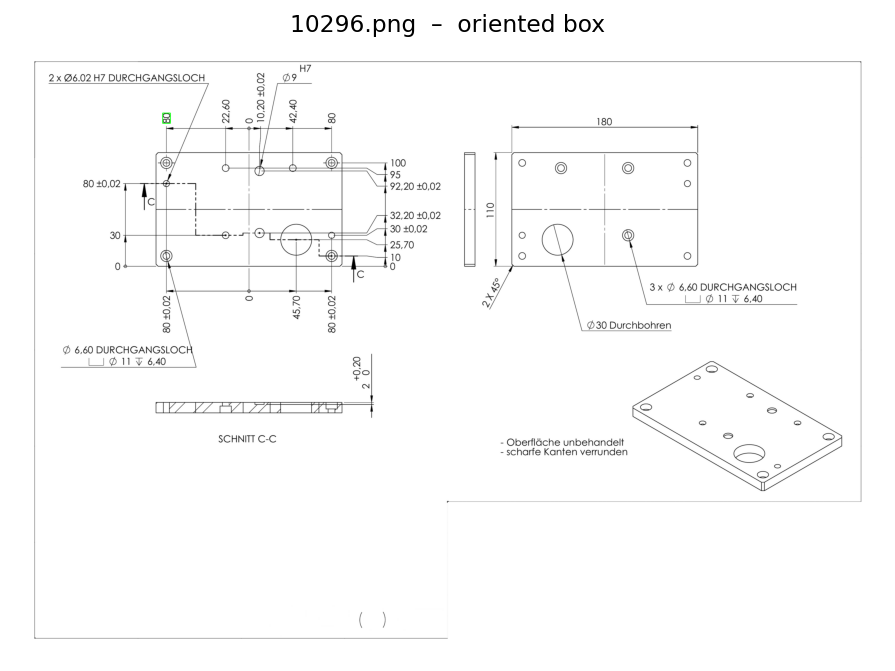

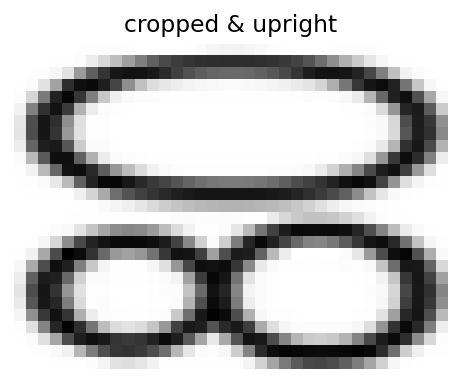

ann_id=205  bbox=[cx=2341.26, cy=658.50, w=42.19, h=21.17, θ=-90.00°]


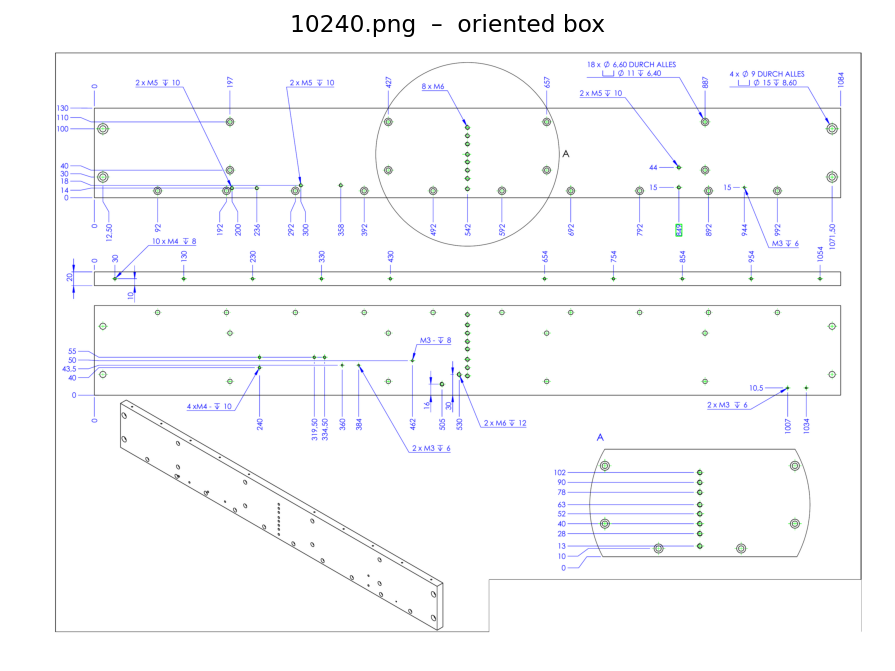

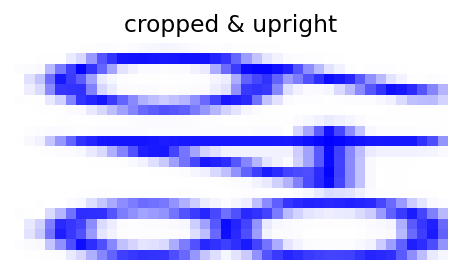

In [52]:
# ════════════════════════════════════════════════════════════════
#  Quick visual sanity-check for rotated COCO boxes
#  – shows the whole page with the polygon
#  – crops the oriented rectangle so that the text block fills the view
# ════════════════════════════════════════════════════════════════
from pathlib import Path
import json, random
import cv2, numpy as np
import matplotlib.pyplot as plt

# ─── adjust your paths ───────────────────────────────────────────
BATCH      = "batch_20250703_02"                         # pick any batch
IMAGES_DIR = Path(f"../data/rotation/batches/{BATCH}/images/default")
ANN_JSON   = Path(f"../data/rotation/batches/{BATCH}/annotations/experiment_coco.json")
# ─────────────────────────────────────────────────────────────────

def load_coco(path: Path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def show_obb_sample(coco, images_dir: Path, ann_indices=None, n=3, seed=None):
    """
    Visualise `n` annotations (or those in ann_indices) with:
      • full image + oriented polygon
      • perspective-corrected crop of just that box
    """
    if seed is not None:
        random.seed(seed)

    id2img = {img["id"]: img for img in coco["images"]}

    # decide which annotations to show
    if ann_indices is None:
        ann_indices = random.sample(range(len(coco["annotations"])), n)

    for idx in ann_indices:
        ann       = coco["annotations"][idx]
        img_meta  = id2img[ann["image_id"]]
        img_path  = images_dir / img_meta["file_name"]

        img_bgr   = cv2.imread(str(img_path))
        if img_bgr is None:
            print("⚠️  could not read", img_path)
            continue
        img_rgb   = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # unpack 5-tuple
        cx, cy, w, h, theta = ann["bbox"]

        # ── draw polygon on the full image ────────────────────────
        #   OpenCV's RotatedRect expects angle counter-clockwise,
        #   so we pass -theta (our θ is clockwise).
        rect = ((cx, cy), (w, h), -theta)
        box  = cv2.boxPoints(rect)               # 4×2 float32
        box  = np.int0(box)

        vis  = img_rgb.copy()
        cv2.polylines(vis, [box], isClosed=True, color=(0, 255, 0), thickness=2)

        # ── produce a perspective-corrected crop ─────────────────
        dst_pts = np.array([[0, 0],
                            [w, 0],
                            [w, h],
                            [0, h]], dtype="float32")

        M    = cv2.getPerspectiveTransform(box.astype("float32"), dst_pts)
        crop = cv2.warpPerspective(img_rgb, M, (int(round(w)), int(round(h))))

        # ── show results ─────────────────────────────────────────
        print(f"ann_id={ann['id']}  bbox=[cx={cx:.2f}, cy={cy:.2f}, w={w:.2f}, h={h:.2f}, θ={theta:.2f}°]")
        plt.figure(figsize=(8, 6))
        plt.title(f"{img_meta['file_name']}  –  oriented box")
        plt.imshow(vis)
        plt.axis("off")

        plt.figure(figsize=(4, 4))
        plt.title("cropped & upright")
        plt.imshow(crop)
        plt.axis("off")
        plt.show()

# ─── run it ──────────────────────────────────────────────────────
coco = load_coco(ANN_JSON)
show_obb_sample(coco, IMAGES_DIR, n=2, seed=42)          # change n / seed as you wish


In [59]:
# ╔══════════════════════════════════════════════════════════════╗
#  Dataset analytics helpers
#  • works with the 5-tuple (cx,cy,w,h,θ) COCO you just created
#  • requires pandas & matplotlib     pip install pandas matplotlib
# ╚══════════════════════════════════════════════════════════════╝




def coco_to_df(coco: Dict[str, Any]) -> pd.DataFrame:
    """Flatten COCO annotations (with rotated bbox) into a tidy DataFrame."""
    img_lookup = {img["id"]: img for img in coco["images"]}
    rows = []
    for ann in coco["annotations"]:
        cx, cy, w, h, theta = ann["bbox"]
        rows.append({
            "ann_id"     : ann["id"],
            "image_id"   : ann["image_id"],
            "file_name"  : img_lookup[ann["image_id"]]["file_name"],
            "img_width"  : img_lookup[ann["image_id"]]["width"],
            "img_height" : img_lookup[ann["image_id"]]["height"],
            "category_id": ann["category_id"],
            "cx"         : cx,
            "cy"         : cy,
            "w"          : w,
            "h"          : h,
            "theta"      : theta,                 # clockwise, degrees
            "area"       : ann.get("area"),
            "iscrowd"    : ann.get("iscrowd", 0),
        })
    return pd.DataFrame(rows)

# ───────────────────── theta exploration ───────────────────────
def analyze_theta(df: pd.DataFrame,
                  nbins: int = 36,
                  show_hist: bool = True) -> None:
    """
    Prints descriptive stats of the rotation angle column and shows a histogram.
    Assumes angles are in degrees, clockwise, any range.
    """
    theta = df["theta"].astype(float)

    # Normalise to (-180, 180] so statistics make sense
    theta_norm = ((theta + 180) % 360) - 180

    print("θ  statistics (degrees, clockwise)")
    print(f"  count:    {len(theta_norm):>6}")
    print(f"  mean:     {theta_norm.mean():8.2f}")
    print(f"  std dev:  {theta_norm.std():8.2f}")
    print(f"  min/max:  {theta_norm.min():8.2f}  …  {theta_norm.max():8.2f}")

    # Top 10 most frequent angles (useful when labels are snapped to 0/90/180/270)
    top = theta_norm.round(1).value_counts().head(10)
    print("\n  most frequent angles:")
    for ang, cnt in top.items():
        print(f"    {ang:6.1f}°   {cnt:>6}")

    if show_hist:
        plt.figure(figsize=(6,4))
        plt.hist(theta_norm, bins=nbins, edgecolor="black")
        plt.title("θ distribution")
        plt.xlabel("θ (deg, clockwise; wrapped to -180…180)")
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()

# ─────────────────── image-level exploration ───────────────────
def analyze_images(coco: Dict[str, Any],
                   top_k: int = 5) -> None:
    """
    Prints image resolution stats and other handy counts.
    """
    widths  = [img["width"]  for img in coco["images"]]
    heights = [img["height"] for img in coco["images"]]
    areas   = [w*h for w, h in zip(widths, heights)]

    print("Image statistics")
    print(f"  total images:       {len(widths):>6}")
    print(f"  size (min / med / max)  :")
    print(f"     width : {min(widths):>6}  …  {int(pd.Series(widths).median()):>6}  …  {max(widths):>6}")
    print(f"     height: {min(heights):>6}  …  {int(pd.Series(heights).median()):>6}  …  {max(heights):>6}")
    print(f"     area  : {min(areas):>8} px² … {int(pd.Series(areas).median()):>8} … {max(areas):>8}")

    # landscape / portrait / square counts
    orientation = collections.Counter(
        "landscape" if w >= h else "portrait" if h > w else "square"
        for w, h in zip(widths, heights)
    )
    print("\n  orientation counts:")
    for k, v in orientation.items():
        print(f"    {k:<9}: {v}")

    # most common individual resolutions
    reso = collections.Counter((w, h) for w, h in zip(widths, heights))
    print(f"\n  top {top_k} resolutions:")
    for (w, h), cnt in reso.most_common(top_k):
        print(f"    {w:>4}×{h:<4}   {cnt} images")



θ  statistics (degrees, clockwise)
  count:      4435
  mean:       -26.70
  std dev:     46.23
  min/max:   -180.00  …    179.70

  most frequent angles:
       0.0°     2240
     -90.0°     1053
       0.1°       74
       0.2°       39
     -90.1°       33
      -0.1°       33
     -89.9°       29
      -0.3°       26
       0.3°       23
       0.6°       23


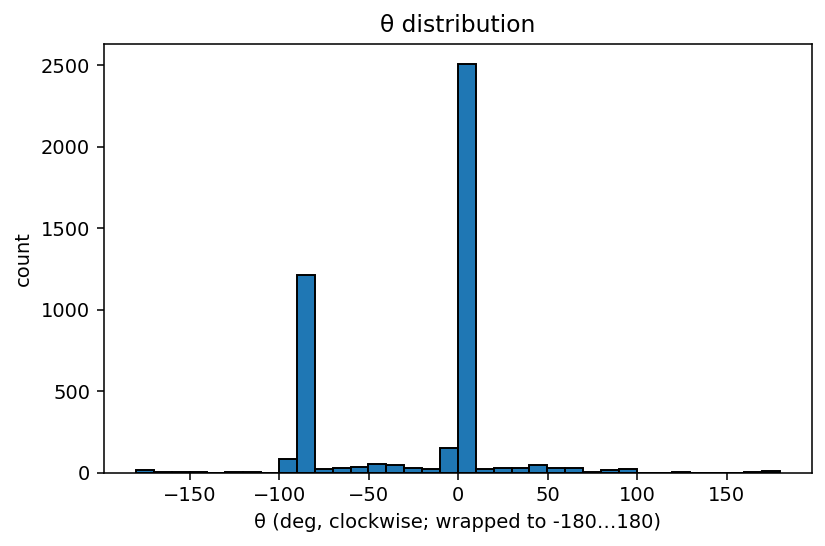

Image statistics
  total images:          100
  size (min / med / max)  :
     width :   2160  …    3055  …    3840
     height:   2160  …    2160  …    3057
     area  :  6220800 px² …  6598800 …  8294400

  orientation counts:
    portrait : 27
    landscape: 73

  top 5 resolutions:
    3056×2160   29 images
    3054×2160   13 images
    2160×3055   13 images
    3055×2160   9 images
    3057×2160   7 images


In [60]:

# ════════════════════════════════════════════════════════════════
#  Example usage
# ════════════════════════════════════════════════════════════════
json_path = Path("../data/rotation/batches/batch_20250703_02/annotations/instances_updated.json")
coco      = load_coco(json_path)
df        = coco_to_df(coco)

analyze_theta(df)     # ↩️ prints stats + shows histogram
analyze_images(coco)  # ↩️ prints resolution info
